Class Counts:
Class
0    284315
1       492
Name: count, dtype: int64

Class Weights: {np.int64(0): np.float64(0.5008652375006595), np.int64(1): np.float64(289.4380081300813)}

Running Experiment 1 (80-20 Split)...

--- Results for Experiment 1 (80-20) ---
Confusion Matrix:
[[56232   632]
 [   10    88]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9889    0.9943     56864
           1     0.1222    0.8980    0.2152        98

    accuracy                         0.9887     56962
   macro avg     0.5610    0.9434    0.6047     56962
weighted avg     0.9983    0.9887    0.9930     56962



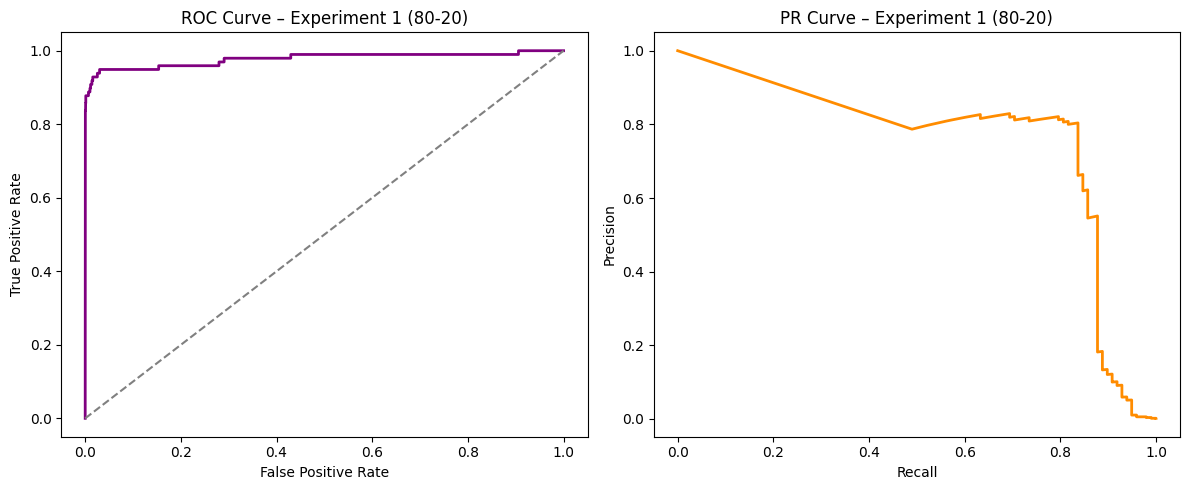


Running Experiment 2 (70-30 Split)...

--- Results for Experiment 2 (70-30) ---
Confusion Matrix:
[[84307   988]
 [   20   128]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9884    0.9941     85295
           1     0.1147    0.8649    0.2025       148

    accuracy                         0.9882     85443
   macro avg     0.5572    0.9266    0.5983     85443
weighted avg     0.9982    0.9882    0.9927     85443



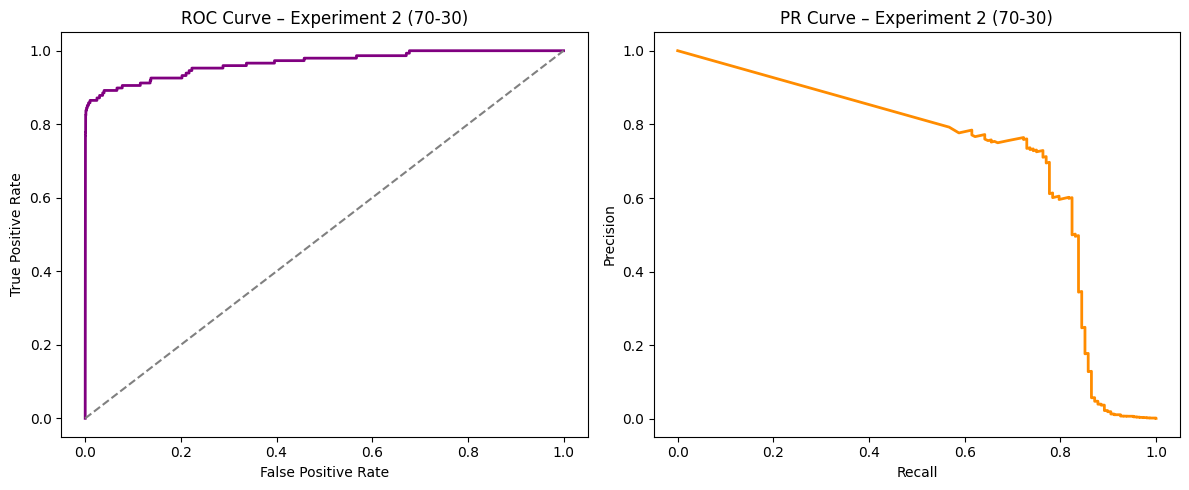


Running Experiment 3 (60-20-20 Split)...

--- Results for Experiment 3 (60-20-20) ---
Confusion Matrix:
[[56286   578]
 [   10    88]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9898    0.9948     56864
           1     0.1321    0.8980    0.2304        98

    accuracy                         0.9897     56962
   macro avg     0.5660    0.9439    0.6126     56962
weighted avg     0.9983    0.9897    0.9935     56962



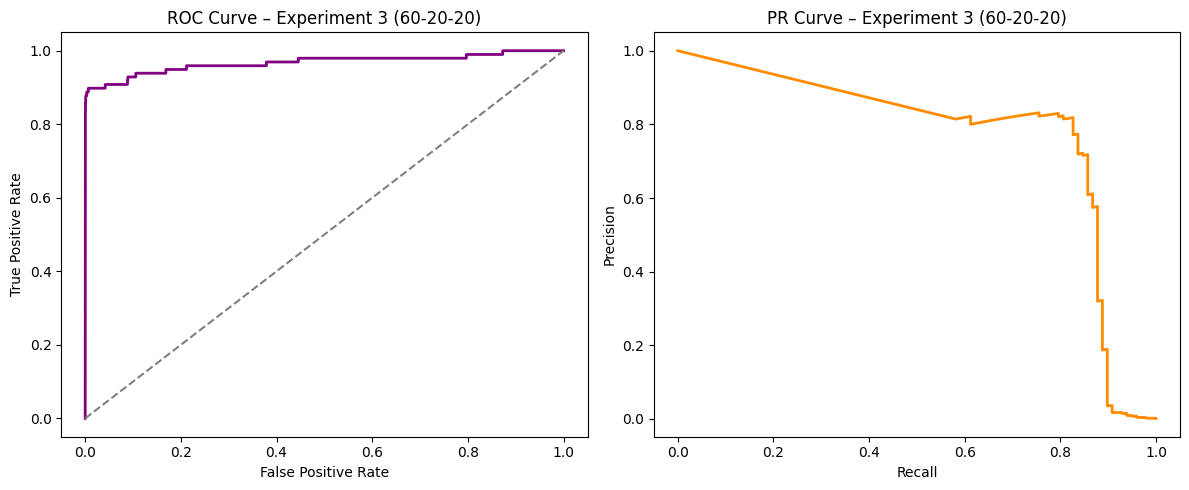


--- Dataset Statistics ---
Imbalance Ratio (Normal : Fraud) = 577.88 : 1


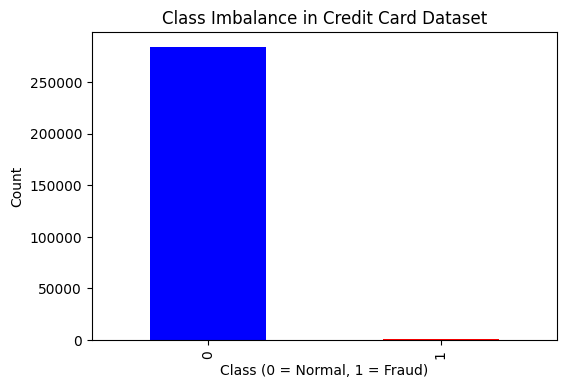

Normal transactions: 284315
Fraud transactions: 492
Fraud percentage: 0.1727%


In [1]:
# 1. IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    precision_recall_curve, auc, roc_curve
)
from sklearn.utils.class_weight import compute_class_weight

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# 2. LOAD AND PREPROCESS DATA
# Ensure 'creditcard.csv' is uploaded to your Colab environment
try:
    df = pd.read_csv("creditcard.csv")
except FileNotFoundError:
    print("Error: 'creditcard.csv' not found. Please upload the dataset to Colab.")

# Separate Features and Target
X = df.drop("Class", axis=1)
y = df["Class"]

# Scale Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Display Class Distribution
print("Class Counts:")
print(df["Class"].value_counts())

# 3. CALCULATE CLASS WEIGHTS (To handle imbalance)
classes = np.unique(y)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y)
class_weight_dict = dict(zip(classes, class_weights))
print("\nClass Weights:", class_weight_dict)

# 4. DEFINE MODEL BUILDING FUNCTION
def build_dnn(input_dim):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(1e-4)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# 5. DEFINE EVALUATION FUNCTIONS
def plot_curves(y_true, y_prob, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)

    plt.figure(figsize=(12, 5))

    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='purple', lw=2)
    plt.plot([0, 1], [0, 1], linestyle="--", color='grey')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – {title}")

    # PR Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='darkorange', lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"PR Curve – {title}")

    plt.tight_layout()
    plt.show()

def evaluate_model(model, X_test, y_test, title):
    y_prob = model.predict(X_test, verbose=0).ravel()
    y_pred = (y_prob > 0.5).astype(int)

    print(f"\n--- Results for {title} ---")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4))

    plot_curves(y_test, y_prob, title)

# 6. RUN EXPERIMENTS

# --- Experiment 1: 80-20 Split ---
print("\nRunning Experiment 1 (80-20 Split)...")
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
model = build_dnn(X_train.shape[1])
model.fit(X_train, y_train, epochs=10, batch_size=256, class_weight=class_weight_dict, verbose=0) # Reduced epochs for speed
evaluate_model(model, X_test, y_test, "Experiment 1 (80-20)")

# --- Experiment 2: 70-30 Split ---
print("\nRunning Experiment 2 (70-30 Split)...")
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=42)
model = build_dnn(X_train.shape[1])
model.fit(X_train, y_train, epochs=10, batch_size=128, class_weight=class_weight_dict, verbose=0)
evaluate_model(model, X_test, y_test, "Experiment 2 (70-30)")

# --- Experiment 3: 60-20-20 Split ---
print("\nRunning Experiment 3 (60-20-20 Split)...")
# First split to get Test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)
# Second split to get Train (60%) and Val (20%) from the remaining 80%
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model = build_dnn(X_train.shape[1])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=256,
          class_weight=class_weight_dict, callbacks=[early_stop], verbose=0)
evaluate_model(model, X_test, y_test, "Experiment 3 (60-20-20)")

# --- Final Stats: Imbalance Ratio ---
print("\n--- Dataset Statistics ---")
class_counts = df["Class"].value_counts()
neg, pos = class_counts[0], class_counts[1]
imbalance_ratio = neg / pos
print(f"Imbalance Ratio (Normal : Fraud) = {imbalance_ratio:.2f} : 1")

plt.figure(figsize=(6, 4))
df['Class'].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.xlabel("Class (0 = Normal, 1 = Fraud)")
plt.ylabel("Count")
plt.title("Class Imbalance in Credit Card Dataset")
plt.show()

print(f"Normal transactions: {neg}")
print(f"Fraud transactions: {pos}")
print(f"Fraud percentage: {(pos/len(df))*100:.4f}%")